<a href="https://colab.research.google.com/github/gowthambalachandhiran/VisualQuestionAnswering/blob/master/VQA_error_free.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

<h1>Welcome to Colaboratory!</h1>


Colaboratory is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud.

With Colaboratory you can write and execute code, save and share your analyses, and access powerful computing resources, all for free from your browser.

In [0]:
#@title Introducing Colaboratory { display-mode: "form" }
#@markdown This 3-minute video gives an overview of the key features of Colaboratory:
from IPython.display import YouTubeVideo
YouTubeVideo('inN8seMm7UI', width=600, height=400)

## Getting Started

The document you are reading is a  [Jupyter notebook](https://jupyter.org/), hosted in Colaboratory. It is not a static page, but an interactive environment that lets you write and execute code in Python and other languages.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [0]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter".

All cells modify the same global state, so variables that you define by executing a cell can be used in other cells:

In [0]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

For more information about working with Colaboratory notebooks, see [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb).


## More Resources

Learn how to make the most of Python, Jupyter, Colaboratory, and related tools with these resources:

### Working with Notebooks in Colaboratory
- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)
- <img src="/img/new.png" height="20px" align="left" hspace="4px" alt="New"></img>
 [TensorFlow 2 in Colab](/notebooks/tensorflow_version.ipynb)

### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb) 
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas](/notebooks/mlcc/intro_to_pandas.ipynb)
- [Tensorflow concepts](/notebooks/mlcc/tensorflow_programming_concepts.ipynb)
- [First steps with TensorFlow](/notebooks/mlcc/first_steps_with_tensor_flow.ipynb)
- [Intro to neural nets](/notebooks/mlcc/intro_to_neural_nets.ipynb)
- [Intro to sparse data and embeddings](/notebooks/mlcc/intro_to_sparse_data_and_embeddings.ipynb)

### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TensorFlow with TPUs](/notebooks/tpu.ipynb)

## Machine Learning Examples: Seedbank

To see end-to-end examples of the interactive machine learning analyses that Colaboratory makes possible, check out the [Seedbank](https://research.google.com/seedbank/) project.

A few featured examples:

- [Neural Style Transfer](https://research.google.com/seedbank/seed/neural_style_transfer_with_tfkeras): Use deep learning to transfer style between images.
- [EZ NSynth](https://research.google.com/seedbank/seed/ez_nsynth): Synthesize audio with WaveNet auto-encoders.
- [Fashion MNIST with Keras and TPUs](https://research.google.com/seedbank/seed/fashion_mnist_with_keras_and_tpus): Classify fashion-related images with deep learning.
- [DeepDream](https://research.google.com/seedbank/seed/deepdream): Produce DeepDream images from your own photos.
- [Convolutional VAE](https://research.google.com/seedbank/seed/convolutional_vae): Create a generative model of handwritten digits.

In [2]:
pip install keras==2.1.0

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import keras
import os, argparse
import cv2, spacy, numpy as np
from keras.layers import Input, LSTM, Embedding, Dense
from keras.applications.vgg16 import VGG16
from keras.models import model_from_json
from keras.optimizers import SGD
from sklearn.externals import joblib
from keras import backend as K
from keras.utils.vis_utils import plot_model
K.set_image_data_format('channels_first')
import csv

In [0]:
from keras.preprocessing import image
from keras.applications import vgg16
from keras.models import Model

In [5]:
model = vgg16.VGG16(weights='imagenet', include_top=True)











Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input

def get_image_features_without_fd(image_file_name,model):
    ''' Runs the given image_file to VGG 16 model and returns the 
    weights (filters) as a 1, 4096 dimension vector '''
    img = image.load_img(image_file_name, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    model_extractfeatures = Model(input=model.input, output=model.get_layer('fc2').output)
    fc2_features = model_extractfeatures.predict(x)
    image_features = fc2_features.reshape(4096)
    return image_features

In [0]:
def get_image_model_without():
    ''' Takes the CNN weights file, and returns the VGG model update 
    with the weights. Requires the file VGG.py inside models/CNN '''
    image_model = VGG16(weights='imagenet', include_top=False)
    image_model.layers.pop()
    image_model.layers.pop()
    # this is standard VGG 16 without the last two layers
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    # one may experiment with "adam" optimizer, but the loss function for
    # this kind of task is pretty standard
    image_model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return image_model

In [8]:
vgg_without = get_image_model_without()

58892288/58889256 [==============================] - 5s 0us/step

Instructions for updating:
keep_dims is deprecated, use keepdims instead



In [0]:
def get_question_features_without_fd(question):
    ''' For a given question, a unicode string, returns the time series vector
    with each word (token) transformed into a 300 dimension representation
    calculated using Glove Vector '''
    word_embeddings = spacy.load('en_core_web_md')
    tokens = word_embeddings(question)
    question_tensor = np.zeros((30, 300))
    for j in range(len(tokens)):
        question_tensor[j,:] = tokens[j].vector
    return question_tensor

In [0]:
from keras.preprocessing import image
from keras.applications import vgg16
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
model = vgg16.VGG16(weights='imagenet', include_top=True)

In [0]:
def get_image_features_without_fd(image_file_name,model):
    ''' Runs the given image_file to VGG 16 model and returns the 
    weights (filters) as a 1, 4096 dimension vector '''
    img = image.load_img(image_file_name, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    model_extractfeatures = Model(input=model.input, output=model.get_layer('fc2').output)
    fc2_features = model_extractfeatures.predict(x)
    image_features = fc2_features.reshape(4096)
    return image_features

In [0]:
def get_VQA_model():
    ''' Given the VQA model and its weights, compiles and returns the model '''

    # thanks the keras function for loading a model from JSON, this becomes
    # very easy to understand and work. Alternative would be to load model
    # from binary like cPickle but then model would be obfuscated to users
    vqa_model = model_from_json(open("/content/model/our_model_final.json").read())
    # vqa_model.load_weights(VQA_weights_file_name)
    vqa_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return vqa_model

In [13]:
our_vqa_model = get_VQA_model()
our_vqa_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_2 (Merge)              (None, 4608)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              4719616   
_________________________________________________________________
activation_5 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_6 (Activation)    (None, 1024)              0         
___________________________

In [17]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 95.4MB 1.3MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.1.0-cp36-none-any.whl size=97126237 sha256=ee594554fbf2cc14e78c8c5d849319b20437f4e9de5a9ae81c3ade2325c4dac9
  Stored in directory: /tmp/pip-ephem-wheel-cache-mmx0i33h/wheels/c1/2c/5f/fd7f3ec336bf97b0809c86264d2831c5dfb00fc2e239d1bb01
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [20]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [22]:
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.0.0/en_core_web_sm-2.0.0.tar.gz --no-deps

     |████████████████████████████████| 37.4MB 65kB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.0.0-cp36-none-any.whl size=37405977 sha256=41bb8a2966262f1b026dc32ac32c55c770bff5d3fe9c5d481a488fa4599f2f01
  Stored in directory: /root/.cache/pip/wheels/54/7c/d8/f86364af8fbba7258e14adae115f18dd2c91552406edc3fdaa
Successfully built en-core-web-sm
  Found existing installation: en-core-web-sm 2.1.0
    Uninstalling en-core-web-sm-2.1.0:
      Successfully uninstalled en-core-web-sm-2.1.0


In [25]:
!pip install spacy

In [0]:
import en_core_web_md

In [0]:
trainY=['yes', 'single', 'multiple', 'foreign', 'yes', 'foreign', 'hand', 'skull', 'skull', 'skull', 'skull', 'hand', 'left', 'left', 'right', 'left', 'right', 'right', 'right', 'right', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'yes', 'yes', 'foreign', 'foreign', 'foreign', 'foreign', 'foreign', 'leg', 'leg', 'leg', 'leg', 'leg', 'leg', 'leg', 'multiple', 'multiple', 'multiple', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes']

In [0]:
trainY_labels = [9, 5, 2, 8, 9, 8, 0, 4, 4, 4, 4, 0, 6, 6, 1, 6, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 9, 9, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 7, 7, 7, 7, 7, 7, 9, 9, 9, 9, 9]

In [57]:
!python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [61]:
import spacy.cli
spacy.cli.download("en_core_web_md")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [62]:
import spacy
spacy.load('en_core_web_md')

In [0]:
word_embeddings = spacy.load('en_core_web_md')

In [0]:
def get_question_features_without_fd(question,word_embeddings):
    ''' For a given question, a unicode string, returns the time series vector
    with each word (token) transformed into a 300 dimension representation
    calculated using Glove Vector '''
    tokens = word_embeddings(question)
    question_tensor = np.zeros((30, 300))
    for j in range(len(tokens)):
        question_tensor[j,:] = tokens[j].vector
    return question_tensor

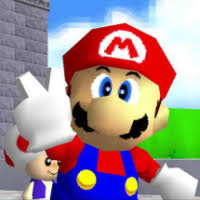

In [82]:
from IPython.display import Image
Image(filename='/content/Images/47.jpg')

In [0]:
def create_image_feature_test(image_path,model):
  image_features = get_image_features_without_fd(image_path,model)
  image_feature_processed = np.array(image_features)
  image_feature_processed = image_feature_processed.reshape((1,image_feature_processed.shape[0]))
  return image_feature_processed

In [0]:
new_image = create_image_feature_test('/content/Images/8.jpg',model)

In [53]:
new_image.shape

(1, 4096)

In [0]:
def create_question_feature_test(text):
  question_feature=get_question_features_without_fd(text,word_embeddings)
  question_feature_processed = np.array(question_feature)  
  question_feature_processed = question_feature_processed.reshape((1,question_feature_processed.shape[0], question_feature_processed.shape[1]))
  return question_feature_processed

In [115]:
training_datas = []
with open('/content/CSV/training.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  for row in csv_reader:
    training_datas.append(row)
training_datas = training_datas[1:]
len(training_datas)

56

In [156]:
trainY= []
for training_data in training_datas:
  img_id,text,output = training_data
  trainY.append(output)
print(len(trainY))
print(trainY)

56
['yes', 'single', 'multiple', 'foreign', 'yes', 'foreign', 'hand', 'skull', 'skull', 'skull', 'skull', 'hand', 'left', 'left', 'right', 'left', 'right', 'right', 'right', 'right', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'yes', 'yes', 'foreign', 'foreign', 'foreign', 'foreign', 'foreign', 'leg', 'leg', 'leg', 'leg', 'leg', 'leg', 'leg', 'multiple', 'multiple', 'multiple', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes']


In [157]:
set_trainy = list(set(trainY))
trainY_labels = []
for y in trainY:
  trainY_labels.append(set_trainy.index(y))
print(trainY_labels)

[1, 6, 3, 4, 1, 4, 2, 8, 8, 8, 8, 2, 0, 0, 5, 0, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 4, 4, 4, 4, 9, 9, 9, 9, 9, 9, 9, 3, 3, 3, 7, 7, 7, 7, 7, 7, 1, 1, 1, 1, 1]


In [0]:

trainY_cate = keras.utils.to_categorical(trainY_labels, num_classes=10)

In [162]:
trainX= []
for training_data in training_datas:
  img_id,text,output = training_data
  print("Processing {} image".format(img_id))
  image_features = get_image_features_without_fd("/content/Images/{}.jpg".format(img_id),model)
  question_features = get_question_features_without_fd(text,word_embeddings)
  trainX.append([question_features,image_features])
np.array(trainX).shape

Processing 1 image
Processing 2 image
Processing 3 image
Processing 4 image
Processing 5 image
Processing 6 image
Processing 7 image
Processing 8 image
Processing 9 image
Processing 10 image
Processing 11 image
Processing 12 image
Processing 13 image
Processing 14 image
Processing 15 image
Processing 16 image
Processing 17 image
Processing 18 image
Processing 19 image
Processing 20 image
Processing 21 image
Processing 22 image
Processing 23 image
Processing 24 image
Processing 25 image
Processing 26 image
Processing 27 image
Processing 28 image
Processing 29 image
Processing 30 image
Processing 31 image
Processing 32 image
Processing 33 image
Processing 34 image
Processing 35 image
Processing 36 image
Processing 37 image
Processing 38 image
Processing 39 image
Processing 40 image
Processing 41 image
Processing 42 image
Processing 43 image
Processing 45 image
Processing 46 image
Processing 47 image
Processing 48 image
Processing 49 image
Processing 50 image
Processing 53 image
Processin

(56, 2)

In [0]:
question_features_array = []
image_features_array = []
for x in trainX:
  question_features_array.append(x[0])
  image_features_array.append(x[1])

In [164]:
question_features_array = np.array(question_features_array)
image_features_array = np.array(image_features_array)
print(question_features_array.shape)
print(image_features_array.shape)

(56, 30, 300)
(56, 4096)


In [165]:
trainY= []
for training_data in training_datas:
  img_id,text,output = training_data
  trainY.append(output)
print(len(trainY))
print(trainY)

56
['yes', 'single', 'multiple', 'foreign', 'yes', 'foreign', 'hand', 'skull', 'skull', 'skull', 'skull', 'hand', 'left', 'left', 'right', 'left', 'right', 'right', 'right', 'right', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'yes', 'yes', 'foreign', 'foreign', 'foreign', 'foreign', 'foreign', 'leg', 'leg', 'leg', 'leg', 'leg', 'leg', 'leg', 'multiple', 'multiple', 'multiple', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes']


In [166]:

set_trainy = list(set(trainY))
trainY_labels = []
for y in trainY:
  trainY_labels.append(set_trainy.index(y))
print(trainY_labels)

[1, 6, 3, 4, 1, 4, 2, 8, 8, 8, 8, 2, 0, 0, 5, 0, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 4, 4, 4, 4, 9, 9, 9, 9, 9, 9, 9, 3, 3, 3, 7, 7, 7, 7, 7, 7, 1, 1, 1, 1, 1]


In [0]:
trainY_cate = keras.utils.to_categorical(trainY_labels, num_classes=10)

In [168]:
history = our_vqa_model.fit([question_features_array,image_features_array],trainY_cate,5,30)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/30
56/56 [==============================] - 12s 211ms/step - loss: 6.0025
Epoch 2/30
56/56 [==============================] - 10s 176ms/step - loss: 3.2999
Epoch 3/30
56/56 [==============================] - 10s 183ms/step - loss: 3.1170
Epoch 4/30
56/56 [==============================] - 10s 181ms/step - loss: 3.4465
Epoch 5/30
56/56 [==============================] - 10s 177ms/step - loss: 3.0316
Epoch 6/30
56/56 [==============================] - 10s 179ms/step - loss: 3.1721
Epoch 7/30
56/56 [==============================] - 10s 176ms/step - loss: 3.1033
Epoch 8/30
56/56 [==============================] - 10s 180ms/step - loss: 2.8754
Epoch 9/30
56/56 [==============================] - 10s 175ms/step - loss: 3.0298
Epoch 10/30
56/56 [=============================

In [0]:
our_vqa_model.save_weights('/content/model_weights_after_training.h5')

# Save the model architecture
with open('/content/model_architecture_after_training.json', 'w') as f:
    f.write(our_vqa_model.to_json())

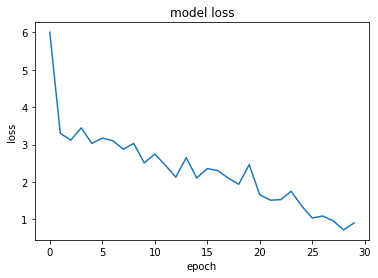

In [170]:

import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [0]:
with open('/content/model_architecture_after_training.json', 'r') as f:
    vqa_model = model_from_json(f.read())

# Load weights into the new model
vqa_model.load_weights('/content/model_weights_after_training.h5')

In [0]:
new_question = create_question_feature_test("is this xray")

In [173]:
new_question.shape

(1, 30, 300)

In [0]:
vqa_model.load_weights('/content/AfterTraining/model_weights_after_training.h5')

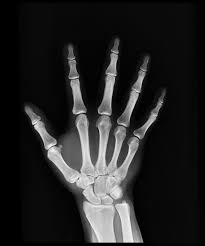

In [218]:
Image(filename='/content/Images/17.jpg')

In [0]:
new_question = create_question_feature_test("is this xray showing foreign body")

In [0]:
new_image = create_image_feature_test('/content/Images/17.jpg',model)

In [229]:
vqa_model.predict_classes([new_question,new_image])

1/1 [==============================] - 0s 56ms/step


array([5])

In [230]:
result=set_trainy[vqa_model.predict_classes([new_question,new_image])[0]]
print(result)

1/1 [==============================] - 0s 49ms/step
right
